In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

%config InlineBackend.figure_format = 'retina'


mpl.rc('axes, unicode_minus = False')

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [ ]:
import easydict
pin = easydict.EasyDict

pin.default_path ="/content/data/MyDrive/playdata/TitanicCompetitionData/"
pin.train_csv = pin.default_path + 'train.csv'
pin.test_csv = pin.default_path + 'test.csv'
pin.default_submission_csv = pin.default_path + 'submission.csv'


pin.save_results = pin.default_path + 'result/model_results.json'

pin.random_state = 0
pin.results = []

In [ ]:
ori_train = pd.read_csv(pin.train_csv)
ori_test = pd.read_csv(pin.test_csv)

In [ ]:
ori_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  393 non-null    int64  
 1   pclass       393 non-null    int64  
 2   name         393 non-null    object 
 3   gender       393 non-null    object 
 4   age          310 non-null    float64
 5   sibsp        393 non-null    int64  
 6   parch        393 non-null    int64  
 7   ticket       393 non-null    object 
 8   fare         392 non-null    float64
 9   cabin        97 non-null     object 
 10  embarked     392 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 33.9+ KB


In [ ]:
ori_train.shape, ori_train.columns

((916, 12),
 Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
        'parch', 'ticket', 'fare', 'cabin', 'embarked'],
       dtype='object'))

In [ ]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [ ]:
ori_train.describe(include = np.number)

,passengerid,survived,pclass,age,sibsp,parch,fare
count,916.000000,916.000000,916.000000,736.000000,916.000000,916.000000,916.000000
mean,457.500000,0.377729,2.292576,29.698370,0.507642,0.361354,32.402710
std,264.570721,0.485084,0.838675,14.185627,1.044866,0.828054,50.506411
min,0.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,228.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,457.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.458300
75%,686.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.017700
max,915.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


# 데이터 전처리

In [ ]:
ori_train.isna().sum(), ori_test.isna().sum()

(passengerid      0
 survived         0
 pclass           0
 name             0
 gender           0
 age            180
 sibsp            0
 parch            0
 ticket           0
 fare             0
 cabin          718
 embarked         1
 name_ch          0
 dtype: int64,
 passengerid      0
 pclass           0
 name             0
 gender           0
 age             83
 sibsp            0
 parch            0
 ticket           0
 fare             1
 cabin          296
 embarked         1
 name_ch          3
 dtype: int64)

In [ ]:
df_for_age = ori_train.copy()

In [ ]:
#name에 포함된 호칭 리스트
ch = list(set(df_for_age.name.str.split().str[1]))
ch = [i for i in ch if '.' in i]
ch += ['Countess', 'Sir', 'Don.']
ch

['Major.',
 'Jonkheer.',
 'Master.',
 'Miss.',
 'Col.',
 'Mlle.',
 'Rev.',
 'Ms.',
 'Dr.',
 'Capt.',
 'Mr.',
 'Don.',
 'Mrs.',
 'Countess',
 'Sir',
 'Don.']

In [ ]:
def name_to_ch(x):
  for i in ch:
    if i in x:
      return i

In [ ]:
df_for_age["name_ch"] = df_for_age["name"].map(lambda x: name_to_ch(x))
df_for_age["name_ch"].value_counts()

Mr.          528
Miss.        185
Mrs.         138
Master.       42
Rev.           6
Dr.            5
Col.           3
Major.         2
Don.           1
Ms.            1
Jonkheer.      1
Mlle.          1
Countess       1
Capt.          1
Sir            1
Name: name_ch, dtype: int64

In [ ]:
#name_ch(호칭) 컬럼 생성
ori_train['name_ch'] = ori_train.name.map(lambda x: name_to_ch(x))
ori_test['name_ch'] = ori_test.name.map(lambda x: name_to_ch(x))

<Axes: xlabel='age', ylabel='name_ch'>

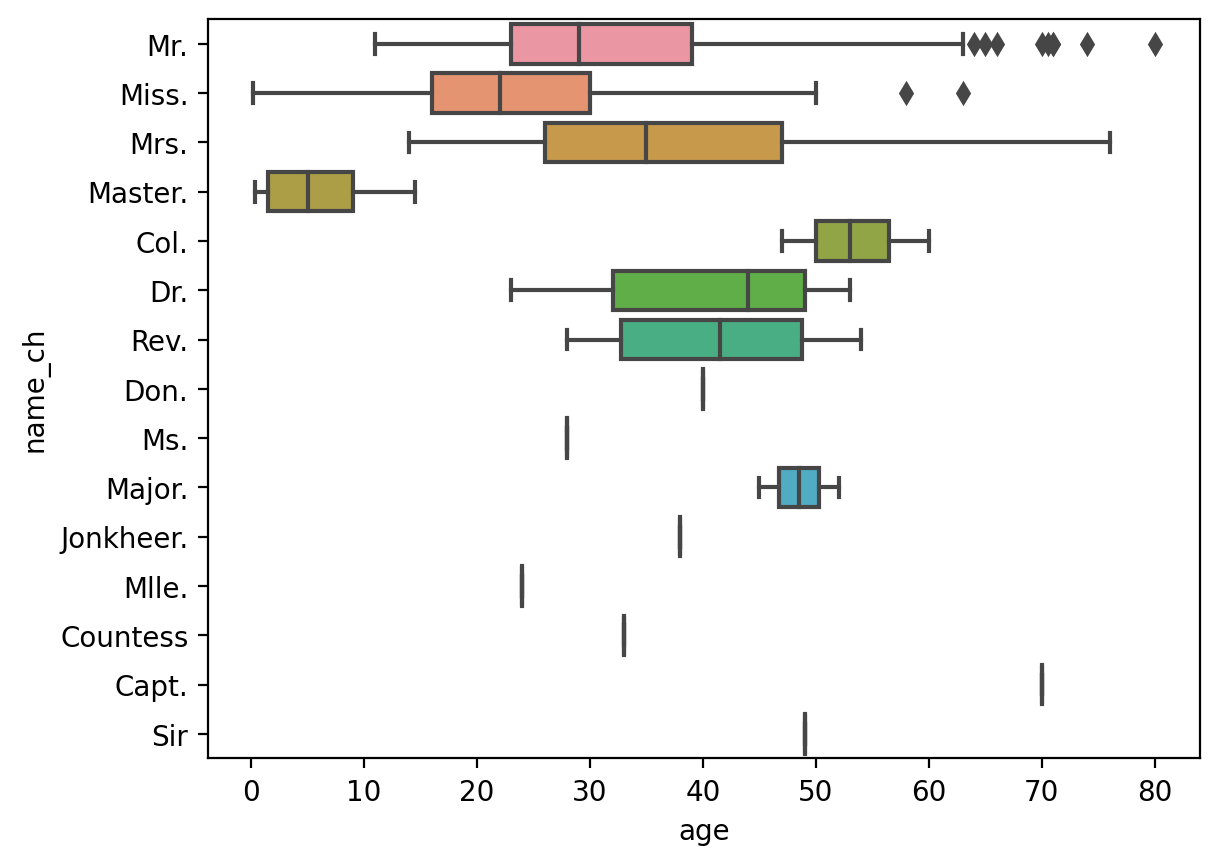

In [ ]:
sns.boxplot(ori_train, x = 'age', y = 'name_ch')

In [ ]:
name_ch_age = df_for_age[['age','name_ch']].groupby(['name_ch']).mean()
name_ch_age.age=round(name_ch_age.age)
name_ch_age.rename(columns = {'age':'age_mean'},inplace = True)
name_ch_age.reset_index(inplace = True)
name_ch_age

,name_ch,age_mean
0,Capt.,70.0
1,Col.,53.0
2,Countess,33.0
3,Don.,40.0
4,Dr.,40.0
5,Jonkheer.,38.0
6,Major.,48.0
7,Master.,5.0
8,Miss.,22.0
9,Mlle.,24.0


# ----------------------------------------------2------------------------------------------------------------

In [ ]:
# age_mean 생성

ori_train2 = ori_train.merge(name_ch_age, how= 'left')
ori_test2 = ori_test.merge(name_ch_age, how= 'left')

In [ ]:
#age_mean으로 age 결측치 처리

ori_train2.age.fillna(ori_train2.age_mean, inplace = True)
ori_test2.age.fillna(ori_test2.age_mean, inplace = True)
ori_train2.age.isna().sum()

0

In [ ]:
ori_train2.pclass = ori_train2.pclass.astype('object')
ori_test2.pclass = ori_test2.pclass.astype('object')

In [ ]:
ori_train2.columns, ori_test2.columns

(Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
        'parch', 'ticket', 'fare', 'cabin', 'embarked', 'name_ch', 'age_mean'],
       dtype='object'),
 Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
        'ticket', 'fare', 'cabin', 'embarked', 'name_ch', 'age_mean'],
       dtype='object'))

In [ ]:
ori_train2.drop(columns = ['age_mean','embarked', 'passengerid','name','name_ch','ticket','cabin'],inplace = True)
ori_test2.drop(columns = ['age_mean','embarked','passengerid','name','name_ch','ticket','cabin'],inplace = True)

In [ ]:
#family 생성
ori_train2['family'] = ori_train2.parch + ori_train2.sibsp
ori_test2['family'] = ori_test2.parch + ori_test2.sibsp

In [ ]:
ori_train2.family.value_counts()

0     558
1     163
2     109
3      26
4      19
5      19
6       9
10      7
7       6
Name: family, dtype: int64

In [ ]:
#family 범주화
ori_train2.family = ori_train2.family.map(lambda x: 4 if x >= 4 else x)
ori_test2.family = ori_test2.family.map(lambda x: 4 if x >= 4 else x)

#sibsp, parch drop
ori_train2.drop(columns = ['sibsp', 'parch'],inplace = True)
ori_test2.drop(columns = ['sibsp', 'parch'],inplace = True)

In [ ]:
#gender
ori_train2.gender = ori_train2.gender.map(lambda x: 0 if x=='male' else 1)
ori_test2.gender = ori_test2.gender.map(lambda x: 0 if x=='male' else 1)

In [ ]:
ori_train2[['family','fare']].groupby('family').mean() 
#동승자 수에 따라 요금 평균이 높아짐

,fare
family,
0,22.109661
1,51.663090
2,36.337690
3,45.922435
4,62.796947


<Axes: xlabel='pclass', ylabel='fare'>

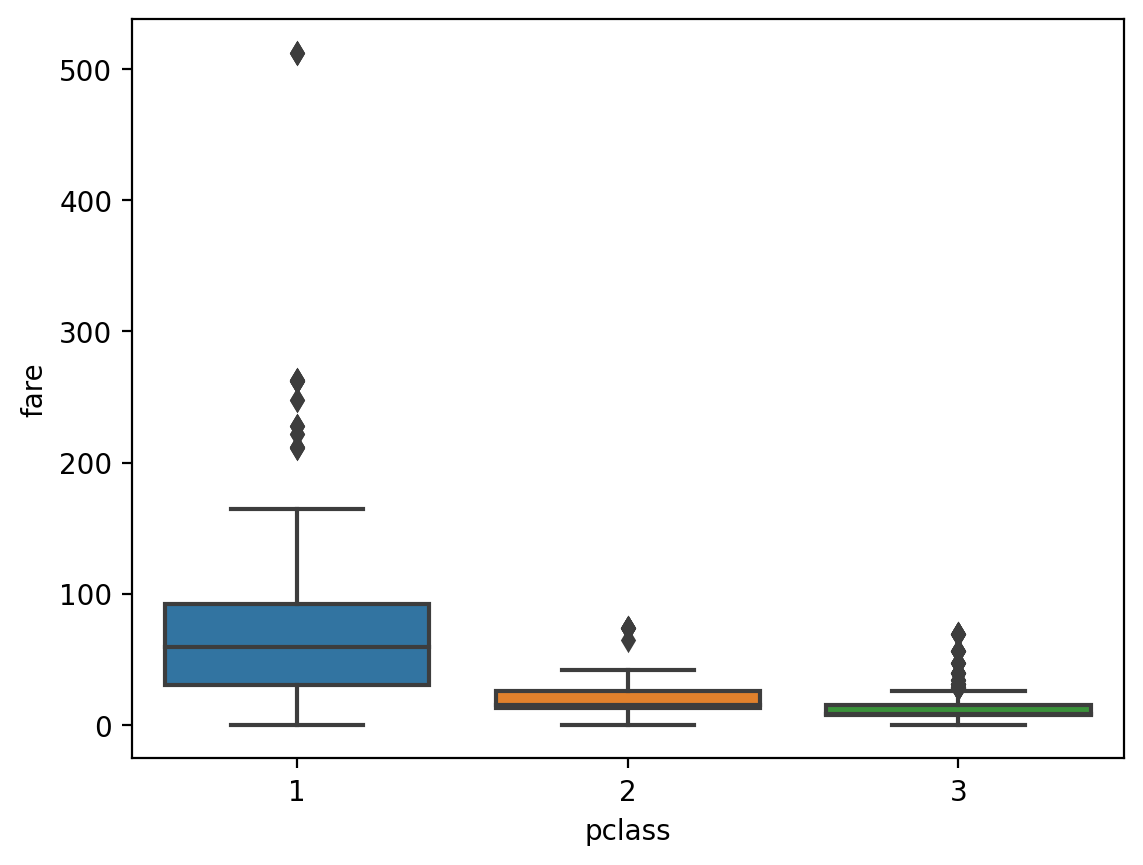

In [ ]:
sns.boxplot(ori_train2,x = 'pclass', y='fare')

In [ ]:
# fare/family
ori_train2.rename(columns = {'fare':'ori_fare'},inplace = True)
ori_train2['fare']= ori_train2.ori_fare / (ori_train2.family+1)
ori_train2.drop(columns = ['ori_fare'], inplace =True)

ori_test2.rename(columns = {'fare':'ori_fare'},inplace = True)
ori_test2['fare']= ori_test2.ori_fare / (ori_test2.family+1)
ori_test2.drop(columns = ['ori_fare'], inplace =True)


#fare결측치 처리(평균)
ori_test2.fare.fillna(ori_train2.fare.mean(), inplace = True)

In [ ]:
ori_train2[['family','fare']].groupby('family').mean()

,fare
family,
0,22.109661
1,25.831545
2,12.112563
3,11.480609
4,12.559389


<Axes: xlabel='pclass', ylabel='fare'>

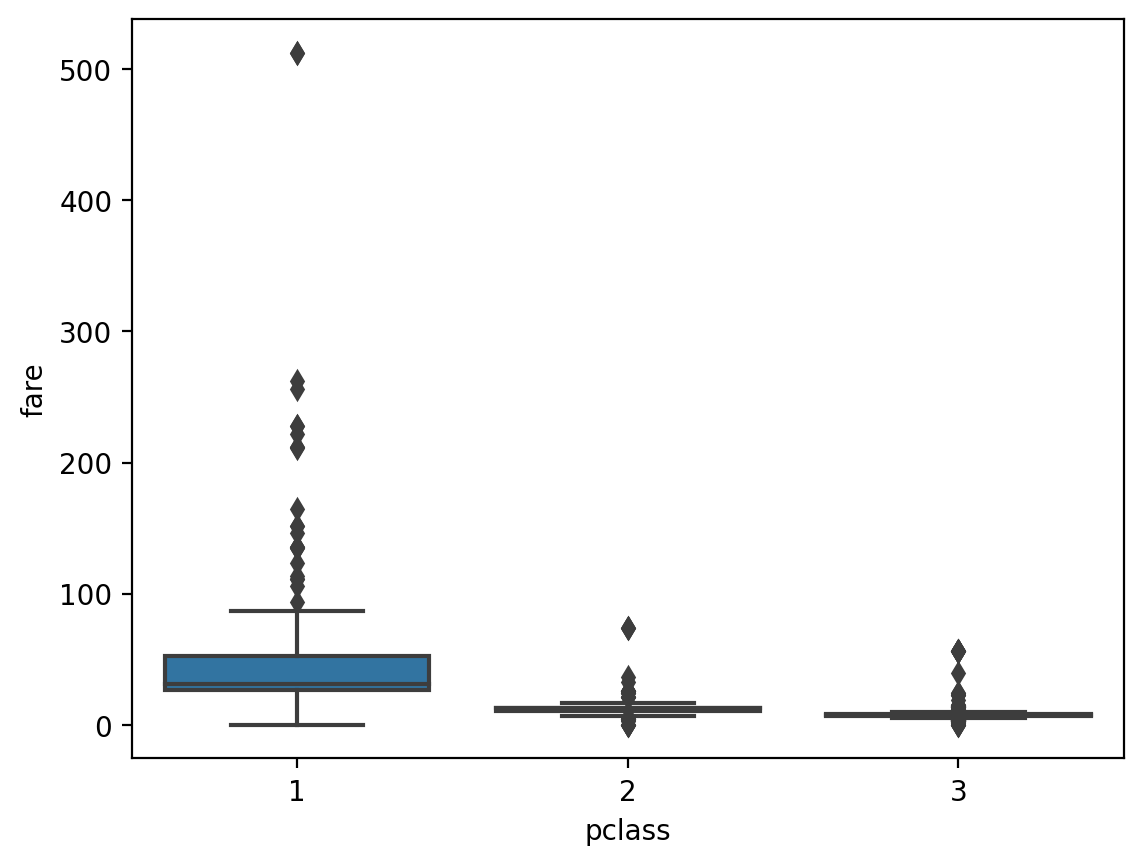

In [ ]:
sns.boxplot(ori_train2,x = 'pclass', y ='fare')

In [ ]:
ori_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  393 non-null    object 
 1   gender  393 non-null    int64  
 2   age     393 non-null    float64
 3   sibsp   393 non-null    int64  
 4   parch   393 non-null    int64  
 5   family  393 non-null    int64  
 6   fare    393 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 24.6+ KB


# 스케일링

In [ ]:
ori_train3 = ori_train2.copy()
ori_test3 = ori_test2.copy()

In [ ]:
 ori_train3[['age','fare']]

,age,fare
0,32.0,12.875000
1,22.0,7.750000
2,52.0,31.166667
3,27.0,7.795800
4,44.0,13.000000
...,...,...
911,32.0,3.218750
912,18.0,8.662500
913,19.0,10.500000
914,22.0,7.733300


In [ ]:
ori_train3.columns

Index(['survived', 'pclass', 'gender', 'age', 'sibsp', 'parch', 'family',
       'fare'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler

cols_scaling = ['age','fare']
scar_tr = ori_train2[cols_scaling]
scar_te = ori_test2[cols_scaling]

std = StandardScaler()
train_scaled = pd.DataFrame(std.fit_transform(scar_tr),columns = ['age', 'fare'])
test_scaled = pd.DataFrame(std.transform(scar_te),columns = ['age', 'fare'])

ori_train3 =  pd.concat([ori_train2[['survived', 'pclass', 'gender', 'family']], train_scaled], axis=1)
ori_test3 =  pd.concat([ori_test2[['pclass', 'gender', 'family']], test_scaled], axis=1)

ori_train3

,survived,pclass,gender,family,age,fare
0,0,2,0,0,0.177217,-0.210134
1,0,3,1,0,-0.589218,-0.348556
2,1,1,1,2,1.710088,0.283909
3,1,3,0,0,-0.206000,-0.347319
4,0,2,0,1,1.096940,-0.206758
...,...,...,...,...,...,...
911,0,3,0,1,0.177217,-0.470941
912,0,3,0,0,-0.895792,-0.323910
913,0,2,0,0,-0.819149,-0.274281
914,1,3,1,0,-0.589218,-0.349007


In [ ]:
from sklearn.preprocessing import MaxAbsScaler

cols_scaling = ['age','fare']
scar_tr = ori_train2[cols_scaling]
scar_te = ori_test2[cols_scaling]

mas = MaxAbsScaler()
train_scaled = pd.DataFrame(mas
.fit_transform(scar_tr),columns = ['age', 'fare'])
test_scaled = pd.DataFrame(mas.transform(scar_te),columns = ['age', 'fare'])

ori_train3 =  pd.concat([ori_train2[['survived', 'pclass', 'gender', 'family']], train_scaled], axis=1)
ori_test3 =  pd.concat([ori_test2[['pclass', 'gender',  'family']], test_scaled], axis=1)

ori_train3

,survived,pclass,gender,family,age,fare
0,0,2,0,0,0.4000,0.078093
1,0,3,1,0,0.2750,0.047008
2,1,1,1,2,0.6500,0.189042
3,1,3,0,0,0.3375,0.047285
4,0,2,0,1,0.5500,0.078852
...,...,...,...,...,...,...
911,0,3,0,1,0.4000,0.019523
912,0,3,0,0,0.2250,0.052542
913,0,2,0,0,0.2375,0.063688
914,1,3,1,0,0.2750,0.046906


In [ ]:
from sklearn.preprocessing import RobustScaler

cols_scaling = ['age','fare']
scar_tr = ori_train2[cols_scaling]
scar_te = ori_test2[cols_scaling]

rbs = RobustScaler()
train_scaled = pd.DataFrame(rbs.fit_transform(scar_tr),columns = ['age', 'fare'])
test_scaled = pd.DataFrame(rbs.transform(scar_te),columns = ['age', 'fare'])

ori_train3 =  pd.concat([ori_train2[['survived', 'pclass', 'gender', 'family']], train_scaled], axis=1)
ori_test3 =  pd.concat([ori_test2[['pclass', 'gender',  'family']], test_scaled], axis=1)

ori_train3

,survived,pclass,gender,family,age,fare
0,0,2,0,0,0.142857,0.250900
1,0,3,1,0,-0.571429,-0.054349
2,1,1,1,2,1.571429,1.340365
3,1,3,0,0,-0.214286,-0.051621
4,0,2,0,1,1.000000,0.258345
...,...,...,...,...,...,...
911,0,3,0,1,0.142857,-0.324234
912,0,3,0,0,-0.857143,0.000000
913,0,2,0,0,-0.785714,0.109443
914,1,3,1,0,-0.571429,-0.055344


In [ ]:
X_train_scaled_ss = rbs.fit_transform(scar_tr).reshape(1832,1)

plt.hist(X_train_scaled_ss, bins=30, color= 'red', alpha = 0.7, density = True)
plt.title('StandardScaler')
plt.show()

NameError: ignored

# 인코딩

In [ ]:
cols_encoding = ["gender",'family','pclass','sibsp', 'parch']
tmp_tr = ori_train3[cols_encoding]
tmp_te = ori_test3[cols_encoding]

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
ori_train3 = ori_train3[['fare','age','survived']]
ori_test3 = ori_test3[['fare', 'age']]

for col in tmp_tr.columns:
  _enco = encoder.fit_transform(tmp_tr[col].astype('category'))
  ori_train3 = pd.concat([ori_train3, _enco], axis=1)

  _enco = encoder.transform(tmp_te[col].astype('category'))
  ori_test3 = pd.concat([ori_test3, _enco], axis=1)

print(f'{ori_train3.shape} / {ori_test3.shape}')
ori_train3.head()

(916, 28) / (393, 27)


,fare,age,survived,gender_0.0,gender_1.0,family_0.0,family_2.0,family_1.0,family_4.0,family_3.0,...,sibsp_2.0,sibsp_4.0,parch_0.0,parch_1.0,parch_2.0,parch_3.0,parch_4.0,parch_6.0,parch_5.0,parch_9.0
0,12.875000,32.0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,7.750000,22.0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,31.166667,52.0,1,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,7.795800,27.0,1,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,13.000000,44.0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
ori_train3.drop(columns = ['family_1.0','family_2.0', 'family_3.0', 'pclass_2.0'],inplace = True)
ori_test3.drop(columns = ['family_1.0','family_2.0', 'family_3.0', 'pclass_2.0'],inplace = True)

# 예측

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = ori_train3['survived']
x = ori_train3.drop(['survived'], axis = 1)

In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(x,y, test_size = 0.3, stratify = ori_train3['survived'], random_state = pin.random_state)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((641, 27), (275, 27), (641,), (275,))

In [ ]:
x_tr.isnull().sum(), ori_test3.isnull().sum()

(fare          0
 age           0
 gender_0.0    0
 gender_1.0    0
 family_0.0    0
 family_2.0    0
 family_1.0    0
 family_4.0    0
 family_3.0    0
 pclass_2.0    0
 pclass_3.0    0
 pclass_1.0    0
 sibsp_0.0     0
 sibsp_1.0     0
 sibsp_8.0     0
 sibsp_5.0     0
 sibsp_3.0     0
 sibsp_2.0     0
 sibsp_4.0     0
 parch_0.0     0
 parch_1.0     0
 parch_2.0     0
 parch_3.0     0
 parch_4.0     0
 parch_6.0     0
 parch_5.0     0
 parch_9.0     0
 dtype: int64,
 fare          0
 age           0
 gender_0.0    0
 gender_1.0    0
 family_0.0    0
 family_2.0    0
 family_1.0    0
 family_4.0    0
 family_3.0    0
 pclass_2.0    0
 pclass_3.0    0
 pclass_1.0    0
 sibsp_0.0     0
 sibsp_1.0     0
 sibsp_8.0     0
 sibsp_5.0     0
 sibsp_3.0     0
 sibsp_2.0     0
 sibsp_4.0     0
 parch_0.0     0
 parch_1.0     0
 parch_2.0     0
 parch_3.0     0
 parch_4.0     0
 parch_6.0     0
 parch_5.0     0
 parch_9.0     0
 dtype: int64)

In [ ]:
train = x_tr.copy()
test = x_te.copy()
ori_te = ori_test3.copy()

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 5.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(verbose = 0).fit(train, y_tr)
cat.score(train, y_tr),cat.score(test, y_te)

(0.9110764430577223, 0.8545454545454545)

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier().fit(train, y_tr)   
lgb.score(train, y_tr),lgb.score(test, y_te)

(0.9609984399375975, 0.8472727272727273)

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier().fit(train, y_tr)   
xgb.score(train, y_tr),xgb.score(test, y_te)

(0.9734789391575663, 0.8436363636363636)

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수

clf = RandomForestClassifier(n_estimators=30, max_depth= 6,random_state=pin.random_state).fit(train,y_tr)
clf.score(train, y_tr),clf.score(test, y_te)

(0.8970358814352574, 0.8472727272727273)

- pclass, gender, age(no cut), family (n_estimators=40, max_depth=5) ->0.8836
- pclass, gender, age(cut), family, 'fare' (n_estimators=30, max_depth=4) ->0.88
- gender(0,1), pclass(1,3), family(0,4) - encoding/ age, fare - int /(n_estimators=40, max_depth=5) / test-size: 0.2 -> 0.8478

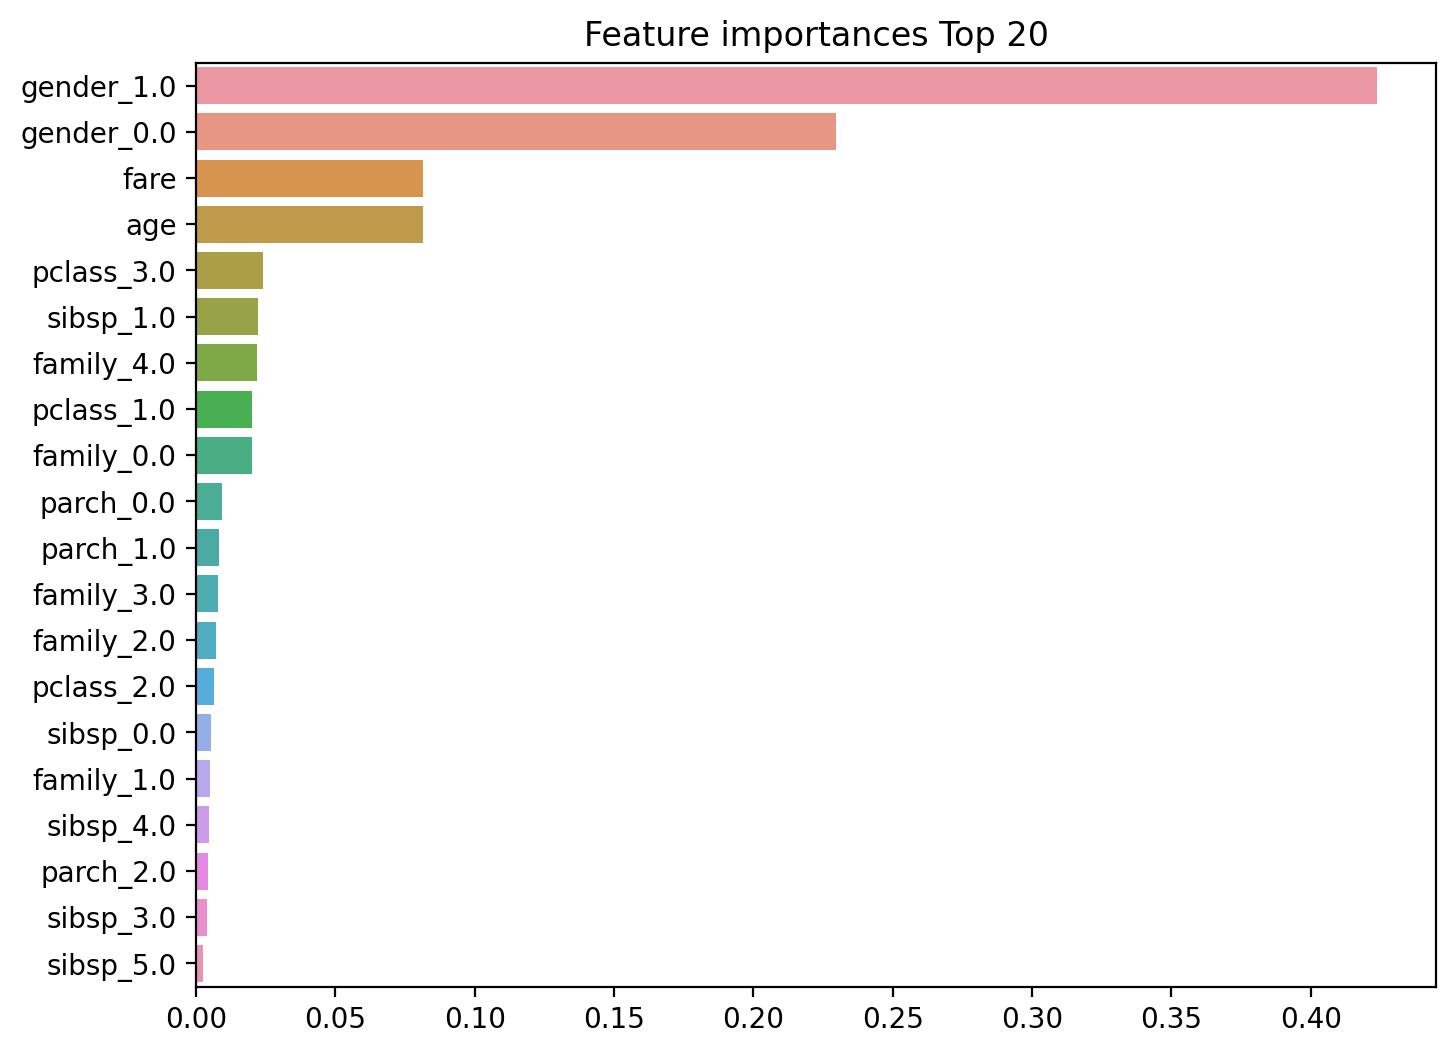

In [ ]:
importances_values = clf.feature_importances_
importances = pd.Series(importances_values, index=train.columns)
top20 = importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x = top20, y = top20.index)
plt.show()

In [ ]:
ori_te_pred = clf.predict_proba(ori_test3)[:,1]
ori_te_pred.shape

In [ ]:
submission = pd.read_csv(pin.default_submission_csv)
submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [ ]:
submission['survived'] = ori_te_pred
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,0.662746
1,917,0.952988
2,918,0.913544
3,919,0.051156
4,920,0.991948
5,921,0.929151
6,922,0.055589
7,923,0.030703
8,924,0.395093
9,925,0.040539


In [ ]:
pin.submission_csv = pin.default_path +'result/'+ str(accuracy_score(y_te,predict1))+'.csv'
submission.to_csv(pin.submission_csv, header=True, index=False)